### Combined Exploratory Data Analysis (EDA) #3  

Data Subject: Livestock & Vehicle Emissions Datasets  

Data Location:(Project SQLite Database)   
C:\Projects\Emissions_Analysis_Capstone\emissions_data\emissionsdata.sqlite

**Process Steps:**  
    0.0 Download Data from Internet or other source  
    0.1 Place data into project repository
    0.2 Import needed dependencies 
    ---  
    1 Read data (initial statistics, column head)  
    2 Transform/clean where needed (strip, lower, rename, replace)  
    3 Push data to an appropriate container (database)  
    4 Generate basic statistics  
    5 Generate functions for visualizations  
    6 Assess visualizations and statistical data.  

**Step 1**  
Import needed dependencies.

In [163]:
# Core libraries
import pandas as pd
import numpy as np
import sqlite3
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning (we’ll use later)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

# Change to project root (adjust as needed)
os.chdir("C:/Projects/Emissions_Analysis_Capstone")

db_path = os.path.join('emissions_data', 'emissionsdata.sqlite')
os.makedirs(os.path.dirname(db_path), exist_ok=True)
conn = sqlite3.connect(db_path)

**Step 2**  
Data Extraction from SQLite Database

In [164]:
# === Livestock query (filtered) ===
livestock_query = """
SELECT
    region,
    animal_type,
    production_system,
    commodity,
    co2_emissions_kg,
    n2o_emissions_kg
FROM livestock_emissions
WHERE region = 'North America'
  AND animal_type = 'Cattle'
  AND production_system = 'Aggregated'
  AND commodity = 'Meat';
"""
livestock_df = pd.read_sql(livestock_query, conn)

'''
# Filter livestock to North America, cattle, meat commodity
cattle_meat_na_df = livestock_df[
    (livestock_df["region"] == "North America") &
    (livestock_df["animal_type"] == "Cattle") &
    (livestock_df["commodity"] == "Meat")
].copy()
'''
cattle_meat_na_df = livestock_df.copy()

# Calculate total cattle CO2 emissions
cattle_total_CO2_kg = cattle_meat_na_df["co2_emissions_kg"].sum()
cattle_total_CO2_million_tonnes = cattle_total_CO2_kg / 1e6

# === Vehicle query ===
vehicle_query = """
SELECT
    make,
    model,
    co2_emissions_g_per_km,
    fuel_type
FROM vehicle_emissions;
"""
vehicle_df = pd.read_sql(vehicle_query, conn)

**Step 3**  
Data Cleaning and Transformation

In [165]:
# Convert CO2 column to numeric
vehicle_df["co2_emissions_g_per_km"] = pd.to_numeric(
    vehicle_df["co2_emissions_g_per_km"], errors="coerce"
)

# Convert g/km → kg/km
vehicle_df["co2_emissions_kg_per_km"] = vehicle_df["co2_emissions_g_per_km"] / 1000

# Multiply by average annual mileage to get kg/year
AVG_KM_PER_YEAR = 16094  # 10,000 miles
vehicle_df["co2_emissions_kg_per_year"] = vehicle_df["co2_emissions_kg_per_km"] * AVG_KM_PER_YEAR

# Dataset aggregates 7 years, divide by NUM_YEARS to get avg per year
NUM_YEARS = 7
vehicle_df["co2_emissions_kg_per_year"] = vehicle_df["co2_emissions_kg_per_year"] / NUM_YEARS

**Step 4**  
Emissions Calculations and Aggregation

In [166]:
# --- Livestock totals ---
cattle_total_CO2_kg = livestock_df["co2_emissions_kg"].sum()
cattle_total_CO2_million_tonnes = cattle_total_CO2_kg / 1e6

# Total vehicles sold in 2015 (NA)
TOTAL_VEHICLES_2015 = 17_470_499
vehicle_total_CO2_kg_2015 = vehicle_df["co2_emissions_kg_per_year"].mean() * TOTAL_VEHICLES_2015
vehicle_total_CO2_million_tonnes = vehicle_total_CO2_kg_2015 / 1e6

# CO2 per vehicle per year
vehicle_CO2_per_vehicle_kg_per_year = vehicle_df["co2_emissions_kg_per_year"].mean()

# === Summary comparison (totals + per-vehicle) ===
summary_df = pd.DataFrame(
    {
        "Category": ["Cattle Meat (NA)", "Vehicles (NA, 2015 sales)"],
        "Total_CO2_kg_per_year": [cattle_total_CO2_kg, vehicle_total_CO2_kg_2015],
        "Total_CO2_million_tonnes_per_year": [
            cattle_total_CO2_million_tonnes,
            vehicle_total_CO2_million_tonnes,
        ],
        "Per_Unit_CO2_kg_per_year": [None, vehicle_CO2_per_vehicle_kg_per_year],
    }
)

print("CO₂ Emissions Comparison (Total + Per Vehicle):")
display(summary_df)

CO₂ Emissions Comparison (Total + Per Vehicle):


,Category,Total_CO2_kg_per_year,Total_CO2_million_tonnes_per_year,Per_Unit_CO2_kg_per_year
0,Cattle Meat (NA),2.891361e+10,28913.607678,NaN
1,"Vehicles (NA, 2015 sales)",1.008830e+10,10088.296884,577.447552


**Step 5**  
Visualizations: Total & Per-Unit Comparisons

C:\Users\derek\AppData\Local\Temp\ipykernel_33316\531278837.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


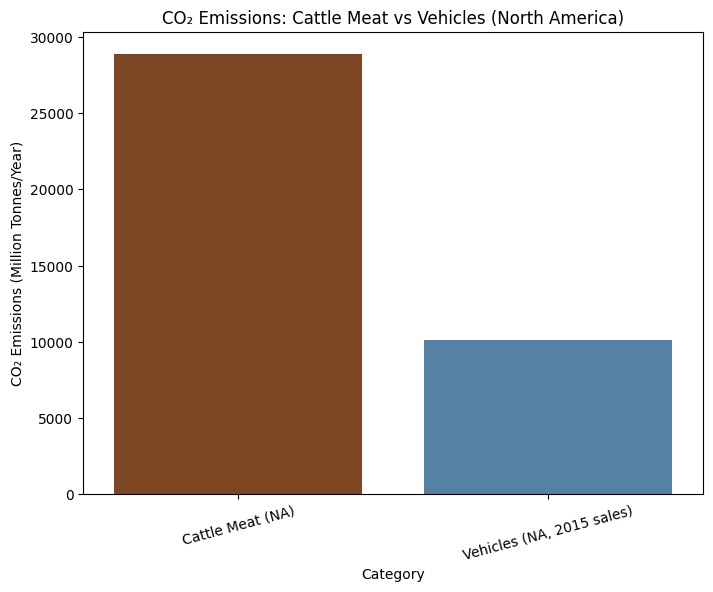

C:\Users\derek\AppData\Local\Temp\ipykernel_33316\531278837.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


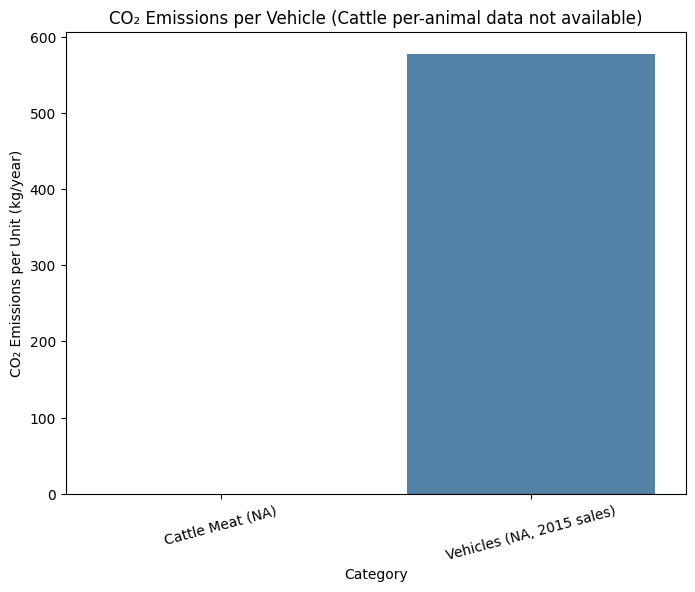

In [167]:
# === Visualization: Total emissions ===
plt.figure(figsize=(8, 6))
sns.barplot(
    x="Category",
    y="Total_CO2_million_tonnes_per_year",
    data=summary_df,
    palette=["saddlebrown", "steelblue"],
)
plt.ylabel("CO₂ Emissions (Million Tonnes/Year)")
plt.title("CO₂ Emissions: Cattle Meat vs Vehicles (North America)")
plt.xticks(rotation=15)
plt.show()

# === Visualization: Per-vehicle emissions ===
plt.figure(figsize=(8, 6))
sns.barplot(
    x="Category",
    y="Per_Unit_CO2_kg_per_year",
    data=summary_df,
    palette=["saddlebrown", "steelblue"],
)
plt.ylabel("CO₂ Emissions per Unit (kg/year)")
plt.title("CO₂ Emissions per Vehicle (Cattle per-animal data not available)")
plt.xticks(rotation=15)
plt.show()

**Step 6**  
Descriptive Statistics

In [168]:
# --- Livestock CO2 statistics ---
print("=== Livestock CO2 Emissions (kg/year) ===")
livestock_stats = livestock_df["co2_emissions_kg"].describe()
display(livestock_stats)

# --- Vehicle CO2 statistics ---
print("\n=== Vehicle CO2 Emissions (kg/year) ===")
vehicle_stats = vehicle_df["co2_emissions_kg_per_year"].describe()
display(vehicle_stats)

=== Livestock CO2 Emissions (kg/year) ===


count    1.000000e+00
mean     2.891361e+10
std               NaN
min      2.891361e+10
25%      2.891361e+10
50%      2.891361e+10
75%      2.891361e+10
max      2.891361e+10
Name: co2_emissions_kg, dtype: float64


=== Vehicle CO2 Emissions (kg/year) ===


count    6282.000000
mean      577.447552
std       136.317160
min       220.717714
25%       478.221714
50%       565.589143
75%       664.452286
max      1200.152571
Name: co2_emissions_kg_per_year, dtype: float64

C:\Users\derek\AppData\Local\Temp\ipykernel_33316\4252716230.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


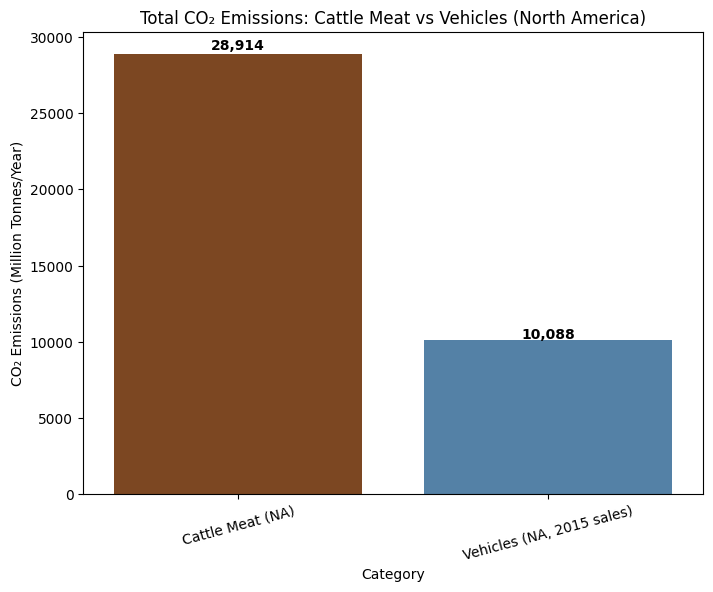

In [169]:
plt.figure(figsize=(8, 6))
sns.barplot(
    x="Category",
    y="Total_CO2_million_tonnes_per_year",
    data=summary_df,
    palette=["saddlebrown", "steelblue"],
)
plt.ylabel("CO₂ Emissions (Million Tonnes/Year)")
plt.title("Total CO₂ Emissions: Cattle Meat vs Vehicles (North America)")
plt.xticks(rotation=15)
for i, v in enumerate(summary_df["Total_CO2_million_tonnes_per_year"]):
    plt.text(i, v * 1.01, f"{v:,.0f}", ha='center', fontweight='bold')
plt.show()

C:\Users\derek\AppData\Local\Temp\ipykernel_33316\115698833.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


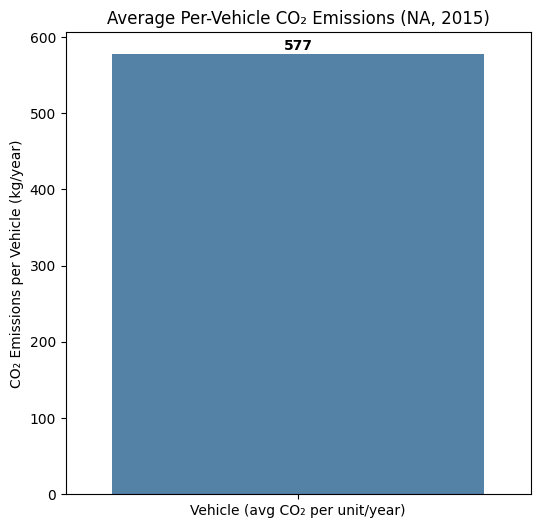

In [170]:
plt.figure(figsize=(6, 6))
sns.barplot(
    x=["Vehicle (avg CO₂ per unit/year)"],
    y=[vehicle_CO2_per_vehicle_kg_per_year],
    palette=["steelblue"],
)
plt.ylabel("CO₂ Emissions per Vehicle (kg/year)")
plt.title("Average Per-Vehicle CO₂ Emissions (NA, 2015)")
plt.text(
    0,
    vehicle_CO2_per_vehicle_kg_per_year * 1.01,
    f"{vehicle_CO2_per_vehicle_kg_per_year:,.0f}",
    ha='center',
    fontweight='bold',
)
plt.show()

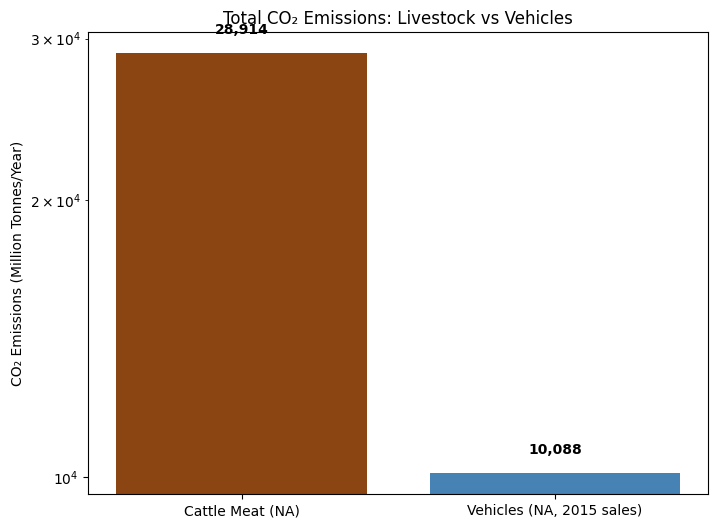

In [171]:
plt.figure(figsize=(8, 6))
totals = [cattle_total_CO2_million_tonnes, vehicle_total_CO2_million_tonnes]
labels = ["Cattle Meat (NA)", "Vehicles (NA, 2015 sales)"]
colors = ["saddlebrown", "steelblue"]

plt.bar(labels, totals, color=colors)
plt.ylabel("CO₂ Emissions (Million Tonnes/Year)")
plt.title("Total CO₂ Emissions: Livestock vs Vehicles")
plt.yscale("log")  # optional, log scale to handle huge differences
for i, v in enumerate(totals):
    plt.text(i, v * 1.05, f"{v:,.0f}", ha='center', fontweight='bold')
plt.show()

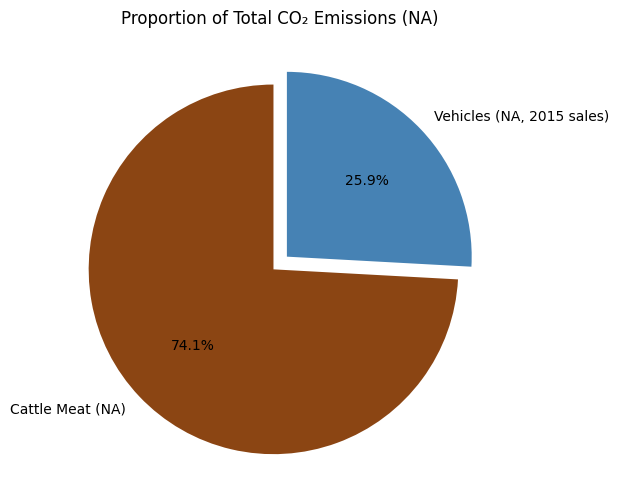

In [172]:
plt.figure(figsize=(6, 6))
plt.pie(
    totals, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, explode=(0.05, 0.05)
)
plt.title("Proportion of Total CO₂ Emissions (NA)")
plt.show()

**Step 7**  
Machine Learning: Vehicle C02 Prediction

In [186]:
# ============================================================
# 7. MACHINE LEARNING: VEHICLE CO₂ PREDICTION
# ============================================================

# --- Encode categorical features ---
vehicle_model_df = pd.get_dummies(vehicle_df, columns=["fuel_type", "make"], drop_first=True)

# --- Define features and target ---
X = vehicle_model_df.drop(
    columns=[
        "model",
        "co2_emissions_g_per_km",
        "co2_emissions_kg_per_km",
        "co2_emissions_kg_per_year",
    ]
)
y = vehicle_model_df["co2_emissions_g_per_km"]

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Linear Regression ---
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(f"Linear Regression RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}")
print(f"Linear Regression R²: {r2_score(y_test, y_pred_lr):.2f}")

Linear Regression RMSE: 46.87
Linear Regression R²: 0.39


Random Forest RMSE: 46.05
Random Forest R²: 0.41


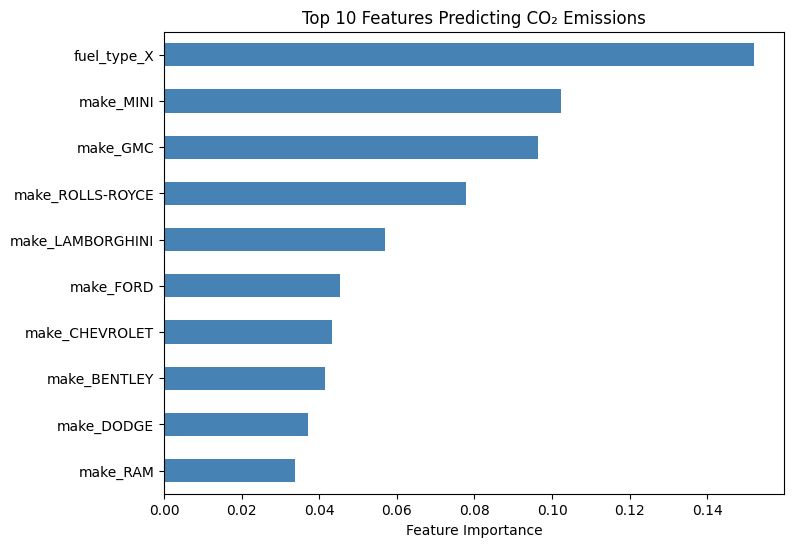

In [200]:
# ============================================================
# 8. RANDOM FOREST REGRESSION & FEATURE IMPORTANCE
# ============================================================

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# --- Evaluate ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rmse:.2f}")
print(f"Random Forest R²: {r2:.2f}")

# --- Feature Importance ---
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top_features = importances.head(10)

plt.figure(figsize=(8, 6))
top_features.plot(kind='barh', color='steelblue')
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Top 10 Features Predicting CO₂ Emissions")
plt.show()

In [201]:
# Assume vehicle_model_df is already one-hot encoded
X = vehicle_model_df.drop(
    columns=[
        "model",
        "co2_emissions_g_per_km",
        "co2_emissions_kg_per_km",
        "co2_emissions_kg_per_year",
    ]
)
y = vehicle_model_df["co2_emissions_g_per_km"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Random Forest RMSE: {rmse:.2f}")
print(f"Random Forest R²: {r2:.2f}")

# Feature importance
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importances.head(10)

Random Forest RMSE: 46.05
Random Forest R²: 0.41


fuel_type_X         0.152149
make_MINI           0.102196
make_GMC            0.096264
make_ROLLS-ROYCE    0.077856
make_LAMBORGHINI    0.056930
make_FORD           0.045384
make_CHEVROLET      0.043361
make_BENTLEY        0.041599
make_DODGE          0.037114
make_RAM            0.033796
dtype: float64

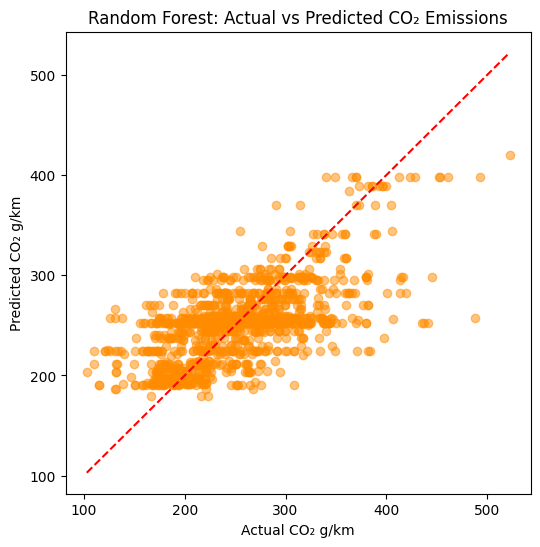

In [213]:
# ============================================================
# 9. MODEL DIAGNOSTICS & COMPARISON VISUALS
# ============================================================

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='darkorange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual CO₂ g/km")
plt.ylabel("Predicted CO₂ g/km")
plt.title("Random Forest: Actual vs Predicted CO₂ Emissions")
plt.show()

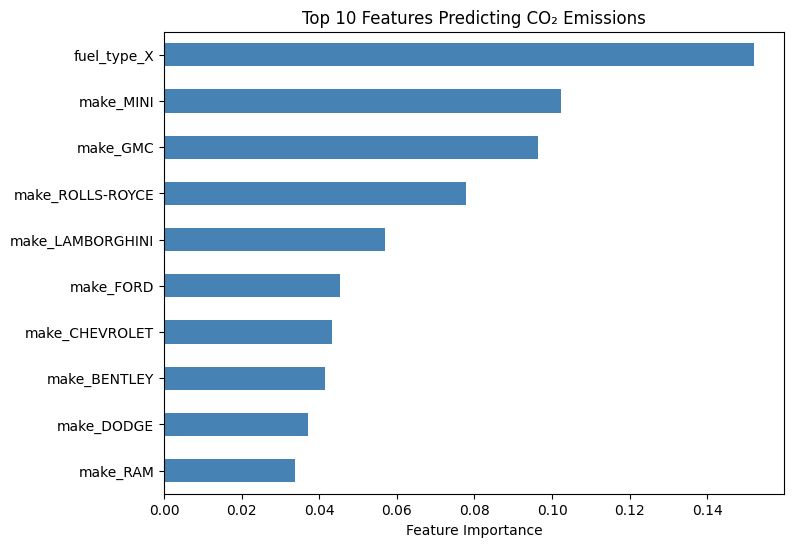

In [214]:
# Feature importance
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 6))
top_features.plot(kind='barh', color='steelblue')
plt.gca().invert_yaxis()  # Highest importance on top
plt.xlabel("Feature Importance")
plt.title("Top 10 Features Predicting CO₂ Emissions")
plt.show()

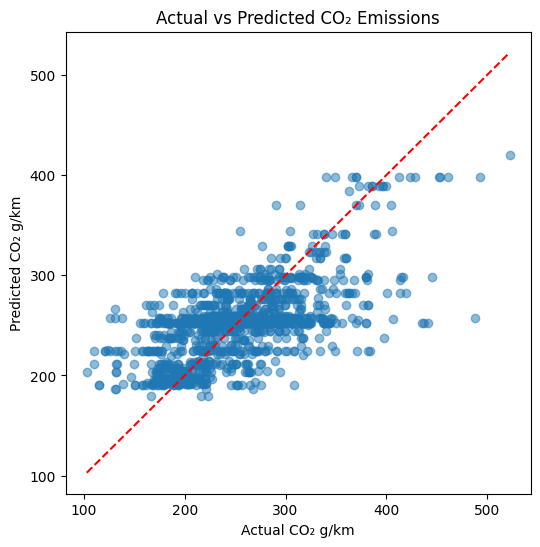

In [215]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual CO₂ g/km")
plt.ylabel("Predicted CO₂ g/km")
plt.title("Actual vs Predicted CO₂ Emissions")
plt.show()

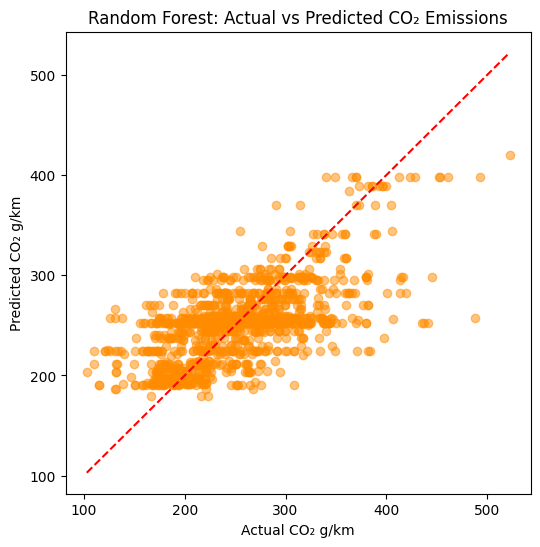

In [216]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='darkorange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual CO₂ g/km")
plt.ylabel("Predicted CO₂ g/km")
plt.title("Random Forest: Actual vs Predicted CO₂ Emissions")
plt.show()

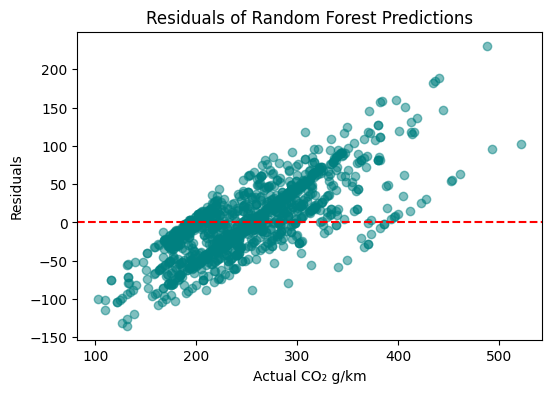

In [217]:
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
plt.scatter(y_test, residuals, alpha=0.5, color='teal')
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Actual CO₂ g/km")
plt.ylabel("Residuals")
plt.title("Residuals of Random Forest Predictions")
plt.show()

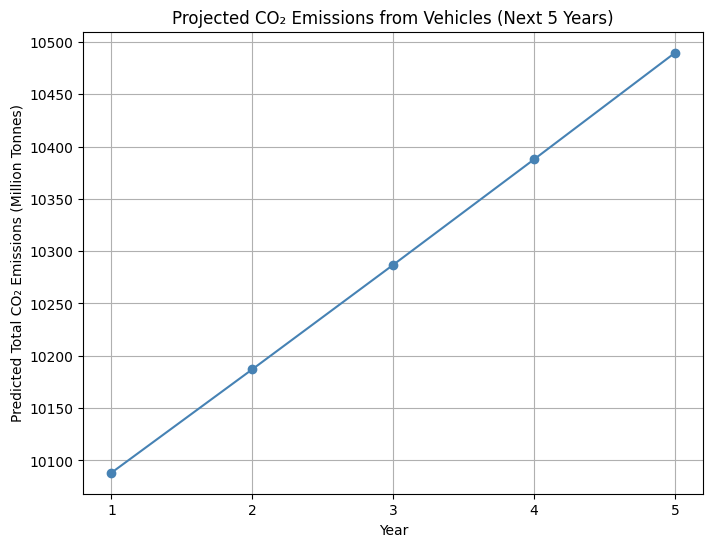

In [218]:
NUM_YEARS = 5
annual_fleet_growth = 0.02  # 2% increase in number of vehicles/year
annual_efficiency_improve = 0.01  # 1% decrease in CO2 per km/year

# Baseline average per-vehicle CO2 (kg/year)
baseline_co2_per_vehicle = vehicle_df["co2_emissions_kg_per_year"].mean()

# Baseline fleet size (number of vehicles)
fleet_size = 17470500  # example: 2015 North America sales

# Initialize list to store yearly predictions
predicted_total_co2 = []

for year in range(NUM_YEARS):
    # Apply fleet growth
    fleet_size_year = fleet_size * ((1 + annual_fleet_growth) ** year)

    # Apply efficiency improvements
    co2_per_vehicle_year = baseline_co2_per_vehicle * ((1 - annual_efficiency_improve) ** year)

    # Total emissions
    total_co2_year = fleet_size_year * co2_per_vehicle_year
    predicted_total_co2.append(total_co2_year / 1e6)  # convert to million tonnes

    years = np.arange(1, NUM_YEARS + 1)  # Year 1, Year 2, ...
plt.figure(figsize=(8, 6))
plt.plot(years, predicted_total_co2, marker='o', linestyle='-', color='steelblue')
plt.xticks(years)
plt.ylabel("Predicted Total CO₂ Emissions (Million Tonnes)")
plt.xlabel("Year")
plt.title("Projected CO₂ Emissions from Vehicles (Next 5 Years)")
plt.grid(True)
plt.show()

c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted

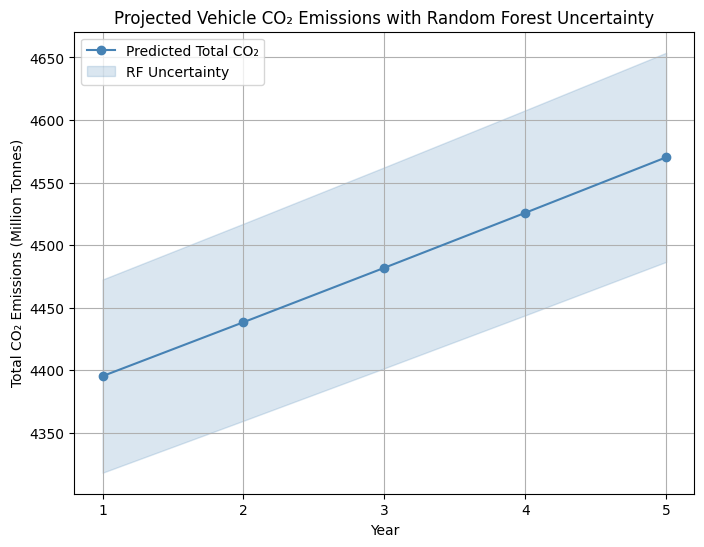

In [219]:
# Assuming 'rf' is your trained RandomForestRegressor
# X_baseline contains features for all vehicles (or average vehicle)
# Here we just use the average vehicle features for simplicity

# Compute predictions for each tree
all_tree_preds = np.array([tree.predict(X_test) for tree in rf.estimators_])

# Compute mean and standard deviation per sample
mean_preds = np.mean(all_tree_preds, axis=0)
std_preds = np.std(all_tree_preds, axis=0)

# Use mean of the mean_preds as baseline per-vehicle CO2
baseline_co2_per_vehicle = np.mean(mean_preds)  # kg/year

NUM_YEARS = 5
annual_fleet_growth = 0.02  # 2% increase per year
annual_efficiency_improve = 0.01  # 1% per year improvement
fleet_size = 17470500  # 2015 NA sales

predicted_total_co2 = []
upper_bound = []
lower_bound = []

for year in range(NUM_YEARS):
    fleet_year = fleet_size * ((1 + annual_fleet_growth) ** year)
    co2_per_vehicle_year = baseline_co2_per_vehicle * ((1 - annual_efficiency_improve) ** year)

    total_co2_year = fleet_year * co2_per_vehicle_year
    predicted_total_co2.append(total_co2_year / 1e6)  # convert to million tonnes

    # Uncertainty bounds
    upper_bound.append((total_co2_year + std_preds.mean() * fleet_year) / 1e6)
    lower_bound.append((total_co2_year - std_preds.mean() * fleet_year) / 1e6)

    years = np.arange(1, NUM_YEARS + 1)

plt.figure(figsize=(8, 6))
plt.plot(years, predicted_total_co2, marker='o', color='steelblue', label="Predicted Total CO₂")
plt.fill_between(
    years, lower_bound, upper_bound, color='steelblue', alpha=0.2, label="RF Uncertainty"
)
plt.xticks(years)
plt.ylabel("Total CO₂ Emissions (Million Tonnes)")
plt.xlabel("Year")
plt.title("Projected Vehicle CO₂ Emissions with Random Forest Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted

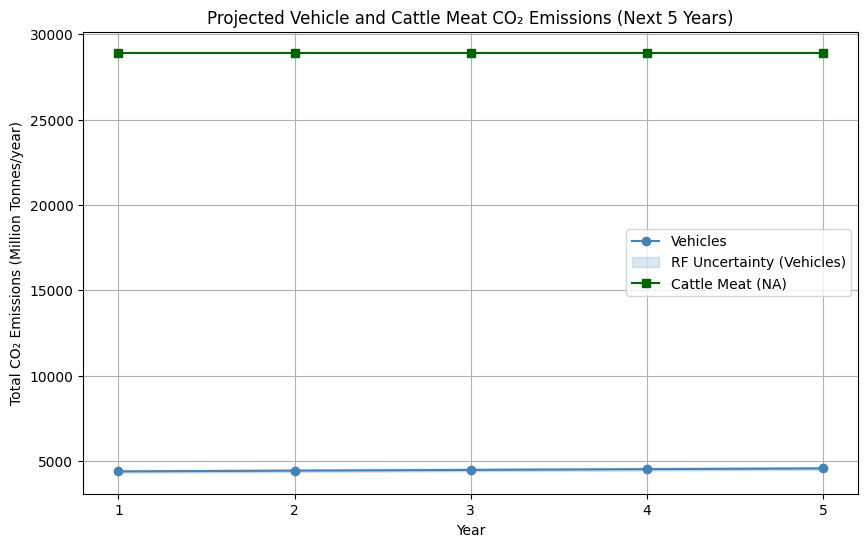

In [220]:
# --- Assumptions ---
NUM_YEARS = 5
annual_vehicle_growth = 0.02  # 2% annual vehicle fleet growth
annual_efficiency_improve = 0.01  # 1% per year efficiency improvement
vehicle_fleet_2015 = 17470500  # 2015 North America vehicle sales

# Filter livestock for North America, Cattle, Meat
cattle_meat_na_df = livestock_df[
    (livestock_df["region"] == "North America")
    & (livestock_df["animal_type"] == "Cattle")
    & (livestock_df["commodity"] == "Meat")
].copy()

# Compute total CO2 (kg/year) and convert to million tonnes
livestock_total_co2 = cattle_meat_na_df["co2_emissions_kg"].sum() / 1e6  # million tonnes
livestock_total_list = [livestock_total_co2] * NUM_YEARS  # repeat for 5 years

# --- Compute Random Forest uncertainty for per-vehicle CO2 ---
# X_test is your vehicle features used previously
all_tree_preds = np.array([tree.predict(X_test) for tree in rf.estimators_])
mean_preds = np.mean(all_tree_preds, axis=0)
std_preds = np.std(all_tree_preds, axis=0)
baseline_co2_per_vehicle = np.mean(mean_preds)  # kg/year

# --- Initialize vehicle lists ---
vehicle_total_co2 = []
vehicle_upper = []
vehicle_lower = []
years = np.arange(1, NUM_YEARS + 1)

for year in range(NUM_YEARS):
    # Vehicle projections
    fleet_year = vehicle_fleet_2015 * ((1 + annual_vehicle_growth) ** year)
    co2_per_vehicle_year = baseline_co2_per_vehicle * ((1 - annual_efficiency_improve) ** year)
    total_co2_year = fleet_year * co2_per_vehicle_year
    vehicle_total_co2.append(total_co2_year / 1e6)  # million tonnes

    # Uncertainty bounds
    vehicle_upper.append((total_co2_year + std_preds.mean() * fleet_year) / 1e6)
    vehicle_lower.append((total_co2_year - std_preds.mean() * fleet_year) / 1e6)

# --- Plot combined projections ---
plt.figure(figsize=(10, 6))

# Vehicle trendline with uncertainty
plt.plot(years, vehicle_total_co2, color='steelblue', marker='o', label="Vehicles")
plt.fill_between(
    years,
    vehicle_lower,
    vehicle_upper,
    color='steelblue',
    alpha=0.2,
    label="RF Uncertainty (Vehicles)",
)

# Livestock trendline
plt.plot(years, livestock_total_list, color='darkgreen', marker='s', label="Cattle Meat (NA)")

plt.xticks(years)
plt.ylabel("Total CO₂ Emissions (Million Tonnes/year)")
plt.xlabel("Year")
plt.title("Projected Vehicle and Cattle Meat CO₂ Emissions (Next 5 Years)")
plt.legend()
plt.grid(True)
plt.show()

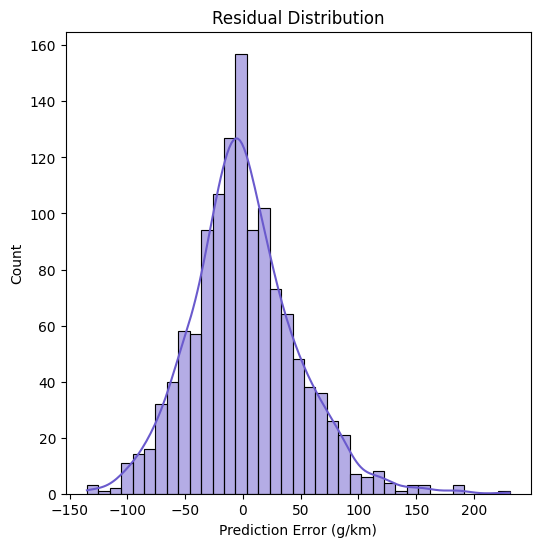

In [221]:
residuals = y_test - y_pred
plt.figure(figsize=(6, 6))
sns.histplot(residuals, kde=True, color='slateblue')
plt.title("Residual Distribution")
plt.xlabel("Prediction Error (g/km)")
plt.show()

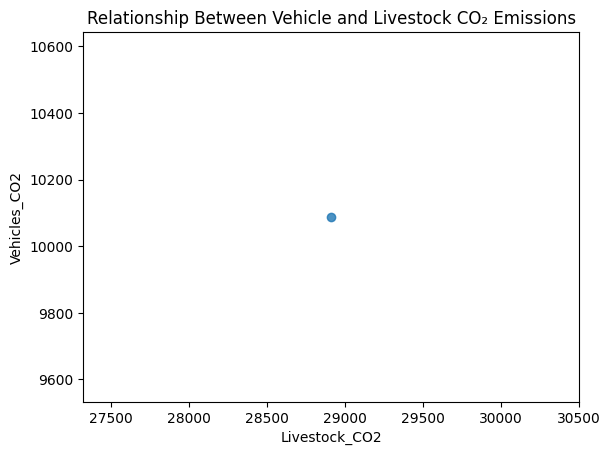

In [222]:
combined_df = pd.DataFrame(
    {
        "Vehicles_CO2": [vehicle_total_CO2_million_tonnes],
        "Livestock_CO2": [cattle_total_CO2_million_tonnes],
    }
)
sns.regplot(x="Livestock_CO2", y="Vehicles_CO2", data=combined_df)
plt.title("Relationship Between Vehicle and Livestock CO₂ Emissions")
plt.show()

c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted

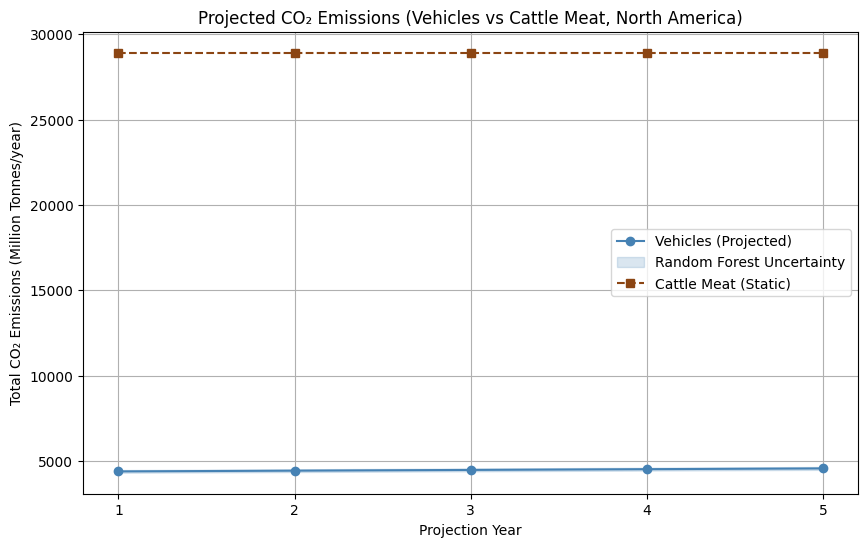

In [223]:
# ================================================================
# 📊 ML-Based Projection of Vehicle and Livestock CO₂ Emissions
# ================================================================
# This section builds on the trained Random Forest model to explore
# future CO₂ emission trends over the next five years.
# It combines:
#   1) Vehicle fleet growth and efficiency assumptions
#   2) Random Forest uncertainty estimation
#   3) Comparison to static livestock emissions (North America, Cattle Meat)
# ================================================================

# --- Assumptions ---
NUM_YEARS = 5
annual_vehicle_growth = 0.02  # 2% annual fleet growth
annual_efficiency_improve = 0.01  # 1% annual efficiency improvement
vehicle_fleet_2015 = 17_470_500  # 2015 North America vehicle sales

# --- Livestock baseline (static) ---
cattle_meat_na_df = livestock_df[
    (livestock_df["region"] == "North America")
    & (livestock_df["animal_type"] == "Cattle")
    & (livestock_df["commodity"] == "Meat")
].copy()

livestock_total_co2 = cattle_meat_na_df["co2_emissions_kg"].sum() / 1e6  # million tonnes
livestock_total_list = [livestock_total_co2] * NUM_YEARS  # assume steady output for comparison

# --- Estimate Random Forest uncertainty on vehicle emissions ---
all_tree_preds = np.array([tree.predict(X_test) for tree in rf.estimators_])
mean_preds = np.mean(all_tree_preds, axis=0)
std_preds = np.std(all_tree_preds, axis=0)
baseline_co2_per_vehicle = np.mean(mean_preds)  # baseline kg/year per vehicle

# --- Initialize projection lists ---
vehicle_total_co2 = []
vehicle_upper = []
vehicle_lower = []
years = np.arange(1, NUM_YEARS + 1)

for year in range(NUM_YEARS):
    # Vehicle fleet projection
    fleet_year = vehicle_fleet_2015 * ((1 + annual_vehicle_growth) ** year)
    co2_per_vehicle_year = baseline_co2_per_vehicle * ((1 - annual_efficiency_improve) ** year)

    total_co2_year = fleet_year * co2_per_vehicle_year
    vehicle_total_co2.append(total_co2_year / 1e6)  # convert to million tonnes

    # Uncertainty bounds (using RF std dev)
    vehicle_upper.append((total_co2_year + std_preds.mean() * fleet_year) / 1e6)
    vehicle_lower.append((total_co2_year - std_preds.mean() * fleet_year) / 1e6)

# --- Plot projections with uncertainty bands ---
plt.figure(figsize=(10, 6))

# Vehicle projection + uncertainty
plt.plot(years, vehicle_total_co2, color='steelblue', marker='o', label="Vehicles (Projected)")
plt.fill_between(
    years,
    vehicle_lower,
    vehicle_upper,
    color='steelblue',
    alpha=0.2,
    label="Random Forest Uncertainty",
)

# Livestock (static) trendline
plt.plot(
    years,
    livestock_total_list,
    color='saddlebrown',
    linestyle='--',
    marker='s',
    label="Cattle Meat (Static)",
)

plt.xticks(years)
plt.ylabel("Total CO₂ Emissions (Million Tonnes/year)")
plt.xlabel("Projection Year")
plt.title("Projected CO₂ Emissions (Vehicles vs Cattle Meat, North America)")
plt.legend()
plt.grid(True)
plt.show()